In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/platesv2/sample_submission.csv
/kaggle/input/platesv2/plates.zip


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random

In [38]:
zip_path = "/kaggle/input/platesv2/plates.zip"
extract_path = "/kaggle/working/platesv2"

os.makedirs(extract_path, exist_ok=True)

# Extract dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    
print("Dataset extracted successfully ✅")

Dataset extracted successfully ✅


In [39]:
train_image_path_clean = "/kaggle/working/platesv2/plates/train/cleaned"
train_image_path_dirty = "/kaggle/working/platesv2/plates/train/dirty"
test_image_path = "/kaggle/working/platesv2/plates/test"

# Load image file names
image_files_clean = [image for image in os.listdir(train_image_path_clean) if image.lower().endswith(('.png', '.jpg', '.jpeg'))]
image_files_dirty = [image for image in os.listdir(train_image_path_dirty) if image.lower().endswith(('.png', '.jpg', '.jpeg'))]
image_files_test = sorted([image for image in os.listdir(test_image_path) if image.lower().endswith(('.png', '.jpg', '.jpeg'))])

In [5]:
pip install -qqq rembg onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 47.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
from rembg import remove

In [40]:
def remove_bg(image_path):
    """Remove background from an image using rembg."""
    with open(image_path, "rb") as f:
        img_data = f.read()
    img_no_bg = remove(img_data)
    img_np = np.frombuffer(img_no_bg, np.uint8)
    img = cv2.imdecode(img_np, cv2.IMREAD_UNCHANGED)
    
    if img.shape[-1] == 4:
        alpha_channel = img[:, :, 3]
        white_background = np.ones_like(img[:, :, :3]) * 255
        img = np.where(alpha_channel[:, :, None] > 0, img[:, :, :3], white_background)
    
    return img

In [ ]:
IMG_SIZE = (224, 224)
train_images, y = [], []

for image_file in tqdm(image_files_clean):
    img_path = os.path.join(train_image_path_clean, image_file)
    img = remove_bg(img_path)
    img = cv2.resize(img, IMG_SIZE)
    train_images.append(img)
    y.append("1")  # Clean

for image_file in tqdm(image_files_dirty):
    img_path = os.path.join(train_image_path_dirty, image_file)
    img = remove_bg(img_path)
    img = cv2.resize(img, IMG_SIZE)
    train_images.append(img)
    y.append("0")  # Dirty

print("Training images loaded and backgrounds removed successfully ✅")

 95%|█████████▌| 19/20 [00:26<00:01,  1.39s/it]

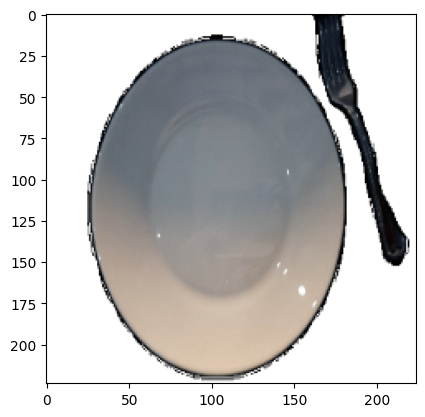

In [9]:
plt.imshow(train_images[2]);

In [10]:
from tqdm import tqdm

test_images = []

for img in tqdm(image_files_test, desc="Loading and removing backgrounds"):
    img_path = os.path.join(test_image_path, img)
    img = remove_bg(img_path)
    img = cv2.resize(img, IMG_SIZE)
    test_images.append(img)

print("Test images loaded and backgrounds removed successfully ✅")


Loading and removing backgrounds: 100%|██████████| 744/744 [00:00<00:00, 2021089.49it/s]

Test images loaded and backgrounds removed successfully ✅


In [11]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-v_on2jy4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-v_on2jy4
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [11]:
import clip

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model = model.float()

# Define dataset class
class PlateDataset(Dataset):
    def __init__(self, images, labels, preprocess):
        self.images = images
        self.labels = labels
        self.preprocess = preprocess

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])  # Convert NumPy to PIL
        image = self.preprocess(image)  # Apply CLIP preprocessing
        label = torch.tensor(int(self.labels[idx]))  # Convert label to tensor
        return image, label

In [13]:
train_dataset = PlateDataset(train_images, y, preprocess)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [14]:
class CLIPClassifier(nn.Module):
    def __init__(self):
        super(CLIPClassifier, self).__init__()
        self.clip_model = model.visual  # CLIP vision encoder
        self.fc = nn.Linear(512, 2)  # Output: 2 classes (clean vs. dirty)

    def forward(self, x):
        with torch.no_grad():  # Freeze CLIP feature extraction
            x = self.clip_model(x)
        return self.fc(x)

In [15]:
classifier = CLIPClassifier().to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.fc.parameters(), lr=0.005)

In [ ]:
num_epochs = 600
for epoch in range(num_epochs):
    classifier.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Accuracy: {(1- (running_loss/len(train_loader))) * 100}%")

print("Training Complete ✅")

In [34]:
# Convert test images to PIL and preprocess them for CLIP
test_dataset = PlateDataset(test_images, [0] * len(test_images), preprocess)  # Labels are dummy (not used)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [35]:
classifier.eval()
predictions = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = classifier(images)
        predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()

        # Convert 1 -> clean, 0 -> dirty
        predictions.extend(["cleaned" if label == 1 else "dirty" for label in predicted_labels])

In [36]:
output_path = "/kaggle/working/final.csv"

# Save predictions to CSV
df = pd.DataFrame({"id": [f"{i:04d}" for i in range(len(predictions))], "label": predictions})
df.to_csv(output_path, index=False)

print(f"Predictions saved to {output_path} ✅")

Predictions saved to /kaggle/working/final.csv ✅
